In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pymc3 as pm
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});


<center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Análisis Explotario de modelos Bayesianos</h1> 
<h2 align="center">Comparasión de modelos</h2>



<br>
<br>
<br>
<br>
<br>

# ArviZ: Análisis exploratorio de datos

<br>
<br>
<center><img src="img/logo_arviz.png" width=400></center>
<br>


* <font color = "gray"> Diagnosticar la calidad de la inferencia </font>
* <font color = "gray"> Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones </font>
* Comparación de modelos, incluyendo la selección y promediado de modelos
* <font color = "gray"> Preparar los resultados para una audiencia particular</font>

## Medidas de exactitud predictiva

* **exactitud dentro de la muestra**: La exactitud de un modelo medida con datos usados para ajustar ese modelo

* **exactitud fuera de la muestra**: La exactitud de un modelo medida con datos NO usados para ajustar ese modelo (también llamada exactitud predictiva)

* Para cualquier combinación de datos y modelos la exactitud dentro de la muestra será, en promedio, menor que la exactitud fuera de la muestra.

* Usar la exactitud dentro de la muestra conducirnos a pensar que tenemos un modelo con mejor capacidad de generalizar que la _real_.

* Usar la exactitud fuera de la muestra tiene el inconveniente de necesitar dejar datos de lado durante el ajuste (lo que aumenta la incertidumbre sobre los valores de los parámetros obtenidos)

* Alternativas:
    * Validad cruzada: Una estrategia basada en dividir los datos disponibles en subconjuntos que son usados para ajustar y luego evaluar el modelo de forma alternada. 
    * Criterios de Información: Familia de métodos para estimar la exactitud predictiva a partir de la exactitud dentro de la muestra

## Criterio de información de Akaike (AIC del inglés Akaike Information Criterion)

* Este es uno de los CI más populares. Y se define como:

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{emv}) + 2 pAIC $$


* Donde $\hat{\theta}_{emv}$ es una estimación puntual obtenida al maximizar la verosimilitud.

* El primer término tiene en cuenta la bondad del ajuste del modelo, mientras que el segundo término penaliza la complejidad del modelo

* La razón de la penalización es que en principio siempre es posible crear un modelo más complejo (o con más parámetros) que logre un mayor ajuste (mayor $\hat{\theta}_{emv}$).

## Criterio de información de Akaike

<br>

* No es un buen método para modelos Bayesianos

* Usa $\hat{\theta}_{emv}$ en vez de la distribución a posteriori de $\theta$

* Asume que un modelo con más parámetros es más complejo, esto no es cierto para modelos jerárquicos o modelos con priors regularizadores o informativos.

* Solo es una buena aproximación cuando el posterior es aproximadamente Gaussiano.

## Criterio de información ampliamente aplicable (WAIC del inglés widely applicable information criterion)

* Se puede pensar como la versión Bayesiana de AIC. 

* Tal como AIC, WAIC tiene términos, uno que mide la bondad del ajuste y el otro que penaliza la complejidad del modelo:

$$ WAIC = -2 \sum_i^n \log\left(\frac{1}{S} \sum_{s=1}^s p(y_i \mid \theta^s) \right) + 2 \sum_i^n \left( \mathop{V}_{s=1}^{S} (\log p(y_i \mid \theta^s) \right)$$ 

* Sin entrar en detalles del como surgen estos términos, podemos ver que:
    * Ambos términos utilizan todo el posterior (se suma sobre las $S$ muestras)
    * Ambos términos utilizan cada una de las observaciones (se suma sobre las $n$ observaciones)

* Desde un punto de vista práctico mientras más pequeño el valor de WAIC _mejor_ será el modelo

## Milk from primates

* We want to explore the composition of milk across several primate species.

* It is hypothesized that females from species of primates with larger brains produce more _nutritious_ milk

* We will use 3 variables
    * The proportion of neocortex compare to the total mass of the brain
    * the logarithm of the body mass of the mothers
    * The kilocalories per gram of milk (predicted variable)
    
* We will fit 3 different linear models:
    1. A model using only the neocortex variable
    2. A model using only the logarithm of the mass variable
    3. A model using both variables

[Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)

In [5]:
d = pd.read_csv('datos/milk.csv')
d.iloc[:,1:] = d.iloc[:,1:] - d.iloc[:,1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-0.123706,-0.831353
1,0.47,-0.030706,0.158647
2,0.56,-0.030706,0.181647
3,0.89,0.000294,-0.579353
4,0.92,0.012294,-1.885353


In [6]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * d['neocortex']
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    trace_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


The acceptance probability does not match the target. It is 0.892165248335771, but should be close to 0.8. Try to increase the number of tuning steps.


In [7]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * d['log_mass']
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


The acceptance probability does not match the target. It is 0.8792955675050164, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal('sigma', 10)

    mu = alpha + pm.math.dot(beta, d[['neocortex','log_mass']].T)

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])

    trace_2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


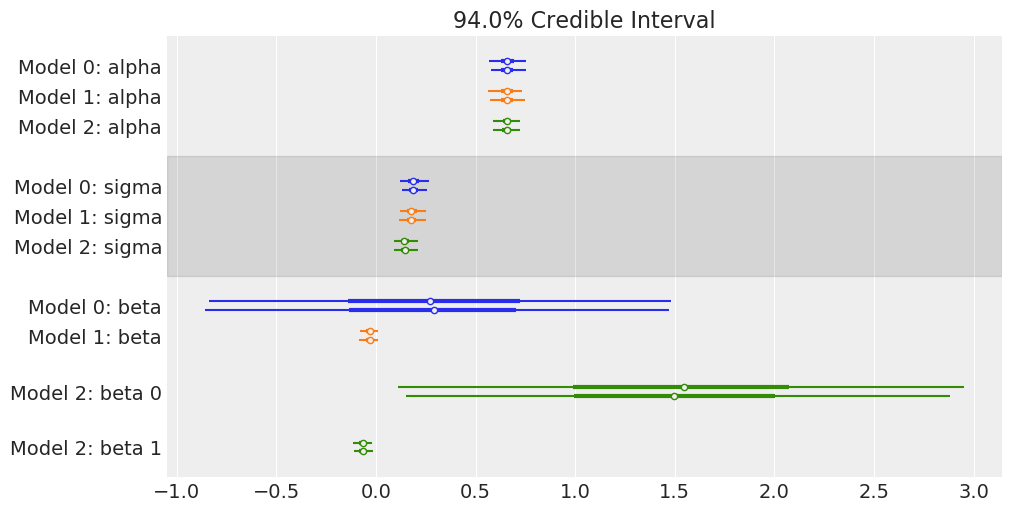

In [9]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

In [10]:
model_dict = dict(zip(['model_0', 'model_1', 'model_2'], traces))
comp = az.compare(model_dict)
comp

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1185: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-15.3749,2.64186,0,0.887329,3.18342,0,True,deviance
model_1,1,-8.79337,2.10948,6.58151,0.0419469,3.98546,2.03682,True,deviance
model_0,2,-7.76828,1.7584,7.6066,0.0707243,4.73866,3.9358,False,deviance


## Interpretando la comparasión

* rank: orden de lo modelos (ordenado de *mejor* a *peor*)
* waic: Los valores de WAIC
* p_waic: _Número efectivo_ de parámetros (no hay que tomarselo muy enserio)
* d_waic: La diferencia relativa entre los valores de WAIC de cada modelo y el modelo mejor rankeado
* weight: Peso relativo (o probabilidad) de cada modelo (dentro de los modelos comparados)
* se: error estándar de WAIC
* dse: error estándard de las diferencias entre los valores de WAIC de cada modelo y el modelo mejor rankeado
* warning: indica si el cómputo de WAIC podría ser poco confiable, se calcula a partir de un valor empírico por lo que debe ser interpretado con cuidado (es más confiable cuado "ic=loo")

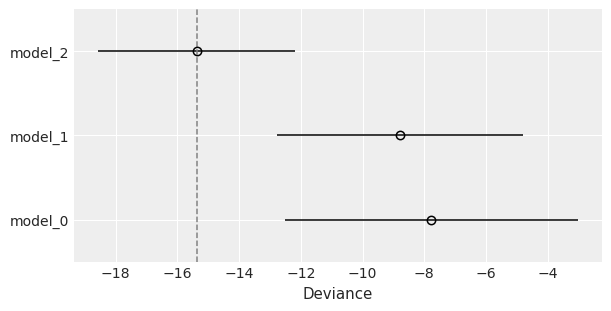

In [11]:
az.plot_compare(comp, insample_dev=False, plot_ic_diff=False);

In [12]:
waic_i_2 = az.waic(trace_0, pointwise=True).waic_i

In [13]:
waic_i_2 = az.waic(trace_2, pointwise=True).waic_i
waic_i_1 = az.waic(trace_1, pointwise=True).waic_i

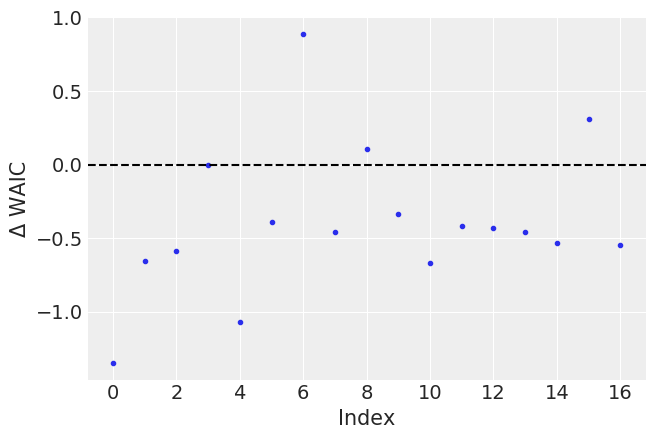

In [14]:
plt.plot(d.index, waic_i_2 - waic_i_1, 'C0.')
plt.axhline(0, color='k', ls='--')
plt.ylabel('Δ WAIC')
plt.xlabel('Index');

## Averaging models

* Instead of choosing the best model we can obtaining a meta-model by averaging all models
* We can use the weights obtained from `az.compare`
* We can use `pm.sample_posterior_predictive_w` to get predictions from the weighted models

In [15]:
# weighted predictions
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, [model_0, model_1, model_2],
                        weights=comp.weight.sort_index(ascending=True))

# predictions from model 2
ppc_2 = pm.sample_posterior_predictive(trace_2, 1000, model_2,
                     progressbar=False)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1254: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


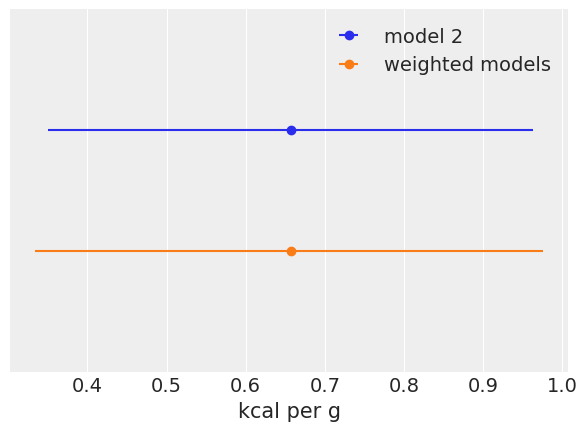

In [18]:
mean_w = ppc_w['kcal'].mean()
hpd_w = az.hpd(ppc_w['kcal']).mean(0)

mean = ppc_2['kcal'].mean()
hpd = az.hpd(ppc_2['kcal']).mean(0)


plt.errorbar(mean, 1, xerr=np.abs([mean - hpd]).T, fmt='o', label='model 2')
plt.errorbar(mean_w, 0, xerr=np.abs([mean_w - hpd_w]).T, fmt='o', label='weighted models')

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('kcal per g')
plt.legend();

# Bayes factors

Let's rewrite Bayes' theorem, making  explicit the dependency of the inference on a given model $M$:

$$p(\theta \mid y, M_k) = {\frac {p(y \mid \theta, M_k)p(\theta \mid M_k)}{p(y \mid M_k)}}$$

The term in the denominator is known as marginal likelihood, the ratio of two maginal likelihoods is known as Bayes Factors:

$$BF = \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

* when BF > 1, model 0 explains data better than model 1

* Using $p(y \mid M_k)$ to compare model is totally fine if all models have the same prior probability

* Otherwise, we have to compute the _posterior odds_:

$$\underbrace{\frac{p(M_0 \mid y)}{p(M_1 \mid y)}}_\text{posterior odds} = \underbrace{\frac{p(y \mid M_0)}{p(y \mid M_1)}}_\text{Bayes factors} \, \underbrace{\frac{p(\ M_0 \ )}{p(\ M_1 \ )}}_\text{prior odds}$$

## Some remarks about Bayes Factors


$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) p(\theta_k, M_k) d\theta_k$$


* The good: Models with more parameters have a larger penalization than models with fewer parameters. The intuitive reason is that the larger the number of parameters the more _spread_ the prior will be with respect to the likelihood.

* The bad: Computing the marginal likelihood is, generally, a hard task because it’s an integral of a highly variable function over a high dimensional parameter space. 

* The ugly: The marginal likelihood depends *sensitively* on the values of the priors

* One relatively simple way to compute BF with PyMC3 is by using the Sequential Monte Carlo sampler

In [20]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_0 = pm.sample_smc(2500)

with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF_1 = pm.sample_smc(2500)
    
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

Sample initial stage: ...
Stage:   0 Beta: 1.000 Steps:  25 Acce: 1.000
Sample initial stage: ...
Stage:   0 Beta: 0.211 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.692 Steps:  25 Acce: 0.711
Stage:   2 Beta: 1.000 Steps:   3 Acce: 0.571


11.135147862982315

## Information Criteria vs Bayes Factors

* Bayes factor are focused on which model is better (and the prior is part of the model)

* WAIC (and LOO) are focused on which model will give the better predictions (priors are taken into account indirectly)

## Exercises

1. compute WAIC and BF for models model_BF_0 and model_BF_1. Use (coins = 30, heads=9) and then (coins=300, heads = 90). Compare the differences in terms of WAIC when increasing the data and in terms of BF when increasing the data. 